# Visualise search process with high-dimensional solutions




# Genetic programming for symbolic regression

In [1]:
!pip install deap
!pip install statannot
!pip install minisom
import random
import numpy
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
sns.set()

     |████████████████████████████████| 163kB 2.8MB/s 
  Created wheel for minisom: filename=MiniSom-2.2.5-cp36-none-any.whl size=8474 sha256=553b3bb30dd2c448a3b6d554054683ccb8c34279b37e75bba53d009b5abcb523
  Stored in directory: /root/.cache/pip/wheels/39/5b/16/cc9402ffc58cafb1da6997e5c94b1bde65e8cb214907879fd4
Successfully built minisom


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# Define new functions
def protectedDiv(left, right):
    with numpy.errstate(divide='ignore',invalid='ignore'):
        x = numpy.divide(left, right)
        if isinstance(x, numpy.ndarray):
            x[numpy.isinf(x)] = 1
            x[numpy.isnan(x)] = 1
        elif numpy.isinf(x) or numpy.isnan(x):
            x = 1
    return x

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(numpy.add, 2, name="vadd")
pset.addPrimitive(numpy.subtract, 2, name="vsub")
pset.addPrimitive(numpy.multiply, 2, name="vmul")
# pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(numpy.negative, 1, name="vneg")
pset.addPrimitive(numpy.cos, 1, name="vcos")
pset.addPrimitive(numpy.sin, 1, name="vsin")
# pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

samples = numpy.linspace(-1, 1, 10000)

def probfunction(x):
  return (x**4 + 2*x + 3*x**3)*(np.cos(x*5))

values = probfunction(samples)

def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the sum of squared difference between the expression
    # and the real function values : x**4 + x**3 + x**2 + x 
    diff = numpy.mean((func(samples) - values)**2)
    return diff,

maxdepth=10
toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=maxdepth))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=maxdepth))

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [11]:
def run_monitor_gp(seed, popsize, ngen, mutateprob, crossprob, pheno_sample):
  random.seed(seed)
  np.random.seed(seed)    
  records = []
  stats = tools.Statistics(key=lambda ind: ind.fitness.values)
  stats.register("avg", numpy.mean)
  stats.register("std", numpy.std)
  stats.register("min", numpy.min)
  stats.register("max", numpy.max)
  pop = toolbox.population(n=popsize)
  CXPB, MUTPB, NGEN = crossprob, mutateprob, ngen

  truth = probfunction(pheno_sample)

  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit

  for g in range(NGEN):
      # Select the next generation individuals
      offspring = toolbox.select(pop, len(pop))
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))
      # Apply crossover and mutation on the offspring        
      offspring = algorithms.varAnd(offspring, toolbox, CXPB, MUTPB)

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      record = stats.compile(pop)
      # print("Gen#{}\t{:8.2f}\t{:8.2f}\t{:8.2f}".format(g, record["min"], record["avg"], record["max"]))
      # records.append([g, record["min"], record["avg"], record["max"]])
      # The population is entirely replaced by the offspring
      for i in range(len(offspring)):
          records.append([g, i, pop[i].fitness.values[0], toolbox.clone(pop[i])] + list((toolbox.compile(expr=pop[i])(pheno_sample) - truth)))

      # topind = tools.selBest(pop, 1)
      # pop = tools.selBest(offspring + topind, len(pop))
      pop[:] = offspring
  return records

In [5]:
def visualise_dimension_reduction(embedding, df):
  plt.subplots(figsize=(10,6))
  plt.scatter(embedding[:,0], embedding[:,1], c=df["gen"], cmap="winter",
              s=10 + 40*(1-(df["fitness"] - df["fitness"].min())/(df["fitness"].max() - df["fitness"].min())), alpha=0.5)
  plt.colorbar()

In [20]:
toolbox.register("select", tools.selTournament, tournsize=5)
pheno_sample=np.linspace(-1, 1, 100)
outputs = np.array(run_monitor_gp(1, 1000, 100, 0.1, 0.9, pheno_sample))
outputs.shape
df = pd.DataFrame(outputs, columns=["gen","id","fitness","prog"] + ["p{}".format(i+1) for i in range(pheno_sample.shape[0])])
df.tail()

,gen,id,fitness,prog,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,...,p61,p62,p63,p64,p65,p66,p67,p68,p69,p70,p71,p72,p73,p74,p75,p76,p77,p78,p79,p80,p81,p82,p83,p84,p85,p86,p87,p88,p89,p90,p91,p92,p93,p94,p95,p96,p97,p98,p99,p100
99995,99,995,0.00171657,"[<deap.gp.Primitive object at 0x7fdfa744d278>,...",0.0247341,-0.0622364,-0.0925626,-0.084983,-0.0552069,-0.0155407,0.02508,0.0607758,0.0882398,0.106178,0.114752,0.115067,0.108744,0.0975858,0.0833415,0.0675509,0.0514665,0.0360298,0.0218854,0.00942131,-0.00118008,-0.00988737,-0.01677,-0.0219565,-0.0256033,-0.0278747,-0.0289329,-0.028935,-0.0280351,-0.0263881,-0.0241525,-0.0214913,-0.0185686,-0.0155451,-0.01257,-0.00977363,...,-0.0039576,-0.00465023,-0.00524305,-0.00567715,-0.00589358,-0.00583388,-0.0054393,-0.00464929,-0.00339998,-0.00162383,0.000748203,0.00378097,0.00752504,0.0120025,0.0171898,0.0229997,0.0292658,0.035733,0.0420579,0.0478226,0.0525629,0.0558126,0.057163,0.0563315,0.0532368,0.0480677,0.0413364,0.033899,0.0269249,0.0217978,0.0199278,0.0224604,0.0298754,0.0414783,0.0548023,0.0649564,0.0639757,0.0402536,-0.0218453,-0.142071
99996,99,996,1.72175,"[<deap.gp.Primitive object at 0x7fdfa744d278>,...",-0.353435,-0.87996,-1.3539,-1.77366,-2.13854,-2.44867,-2.70487,-2.90862,-3.06198,-3.16753,-3.22834,-3.24785,-3.22988,-3.17847,-3.0978,-2.99216,-2.86574,-2.72266,-2.5668,-2.4018,-2.23095,-2.05724,-1.88327,-1.71131,-1.54327,-1.38076,-1.2251,-1.07737,-0.938425,-0.808943,-0.689429,-0.580242,-0.481595,-0.393562,-0.316067,-0.248891,...,-0.0504526,-0.0667068,-0.0851936,-0.105546,-0.127257,-0.149685,-0.172071,-0.193551,-0.213175,-0.229929,-0.242758,-0.250602,-0.252424,-0.24726,-0.234263,-0.212753,-0.18227,-0.142624,-0.093937,-0.0366794,0.0283109,0.0998215,0.176275,0.255758,0.336061,0.414741,0.489186,0.556688,0.614521,0.659994,0.6905,0.703532,0.69666,0.667474,0.613483,0.531962,0.419761,0.273057,0.0870848,-0.14418
99997,99,997,0.00171951,"[<deap.gp.Primitive object at 0x7fdfa744d278>,...",0.026843,-0.0607387,-0.0915759,-0.0843993,-0.0549167,-0.0154392,0.0250872,0.0607677,0.0882762,0.106298,0.114972,0.115383,0.109135,0.0980178,0.0837716,0.0679334,0.0517582,0.0361942,0.0218967,0.00926674,-0.00149875,-0.0103538,-0.0173543,-0.0226175,-0.0262919,-0.0285377,-0.029517,-0.0293917,-0.0283244,-0.026482,-0.0240371,-0.0211675,-0.0180522,-0.0148645,-0.0117639,-0.00888709,...,-0.00472087,-0.00550133,-0.00614882,-0.00659642,-0.00678012,-0.00664003,-0.00611991,-0.00516576,-0.00372377,-0.0017393,0.00084212,0.0040703,0.00798171,0.0125866,0.0178527,0.0236884,0.0299268,0.0363172,0.0425243,0.0481413,0.0527174,0.0558013,0.0569985,0.0560398,0.0528543,0.0476376,0.0409045,0.0335077,0.0266089,0.0215782,0.0198082,0.022424,0.0298835,0.0414711,0.0547008,0.0646662,0.063392,0.0392669,-0.023343,-0.14418
99998,99,998,0.00646913,"[<deap.gp.Primitive object at 0x7fdfa744d278>,...",0.0573159,-0.0448662,-0.0852884,-0.0832061,-0.0552624,-0.0148977,0.0277903,0.0658564,0.0951031,0.113563,0.120948,0.118134,0.106702,0.0885748,0.0657437,0.0400802,0.0132248,-0.013466,-0.0389292,-0.0623749,-0.0832506,-0.101199,-0.116014,-0.127608,-0.135981,-0.141203,-0.143403,-0.142761,-0.139511,-0.133937,-0.126366,-0.117169,-0.106741,-0.0954905,-0.0838258,-0.0721332,...,0.0253713,0.03215,0.0396726,0.0478261,0.0564659,0.0654219,0.0745061,0.0835226,0.0922778,0.10059,0.108297,0.115257,0.121351,0.126472,0.130519,0.133378,0.134917,0.134977,0.133369,0.129893,0.124359,0.116627,0.106659,0.0945732,0.0807074,0.0656656,0.0503475,0.0359407,0.0238579,0.0156021,0.0125437,0.0155971,0.0247948,0.0387679,0.0541593,0.0650119,0.0621988,0.0329793,-0.0392154,-0.174653
99999,99,999,0.0371369,"[<deap.gp.Primitive object at 0x7fdfa744d278>,...",0.22865,0.0723075,-0.0159862,-0.0516039,-0.0489611,-0.0207807,0.0223104,0.0719075,0.121746,0.167476,0.206363,0.236951,0.258745,0.271923,0.277102,0.27515,0.267059,0.253852,0.23653,0.216041,0.193271,0.169039,0.144101,0.119146,0.0947995,0.07

Text(0, 0.5, 'Best Fitness')

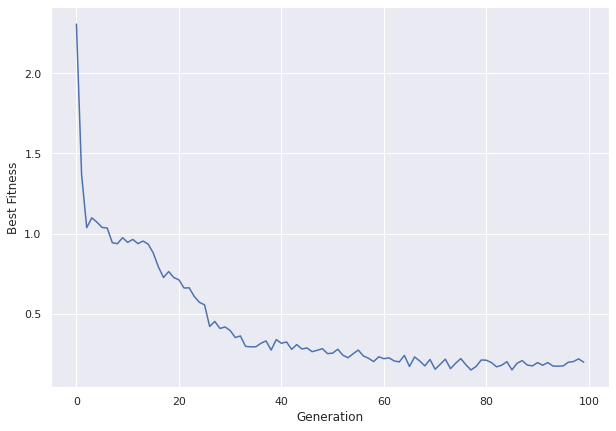

In [23]:
df = df.astype({c: float for c in df.columns if c!="prog"})
df = df.astype({"prog":str})
groupdf = df.drop(columns=["prog"]).groupby(['gen']).agg("mean").reset_index()
plt.figure(figsize=(10,7))
ax = sns.lineplot(x="gen", y="fitness", data=groupdf)
ax.set_xlabel("Generation")
ax.set_ylabel("Best Fitness")

             p1        p2        p3  ...       p98       p99      p100
0      0.578653  0.576003  0.573451  ...  0.754277  0.714196  0.658871
1      0.572776  0.570746  0.568928  ...  0.652658  0.624171  0.581142
2      0.504510  0.497338  0.489948  ...  0.756542  0.715191  0.658871
3      0.578653  0.576003  0.573451  ...  0.754277  0.714196  0.658871
4      0.578653  0.576806  0.575173  ...  0.644443  0.616658  0.574450
...         ...       ...       ...  ...       ...       ...       ...
99995  0.500436  0.505509  0.514320  ...  0.729897  0.718027  0.682505
99996  0.486416  0.472348  0.458308  ...  0.743495  0.723504  0.682416
99997  0.500514  0.505570  0.514364  ...  0.729839  0.717951  0.682416
99998  0.501644  0.506213  0.514643  ...  0.729472  0.717153  0.681130
99999  0.507995  0.510965  0.517721  ...  0.720200  0.702441  0.661948

[100000 rows x 100 columns]


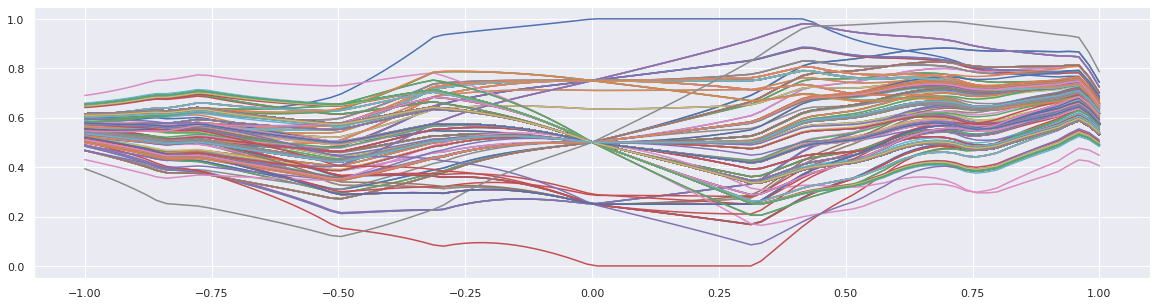

In [24]:
train_df = df.drop(["gen", "fitness","id","prog"], axis=1)
minval = np.min(train_df.values)
maxval = np.max(train_df.values)
rangeval = maxval - minval
# print(minval, rangeval)
normalized_df=(train_df-train_df.min())/(train_df.max()-train_df.min())
# normalized_df=(train_df-minval)/rangeval

# normalized_df = (train_df).apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)
plt.figure(figsize=(20,5))
for i in range(1000):
  plt.plot(pheno_sample, normalized_df.iloc[5*i,:])
# plt.ylim(0,1)
print(normalized_df)

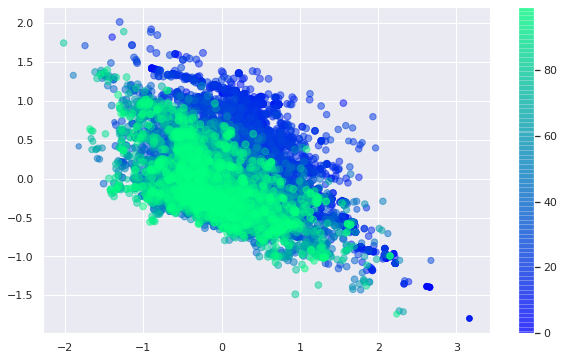

In [25]:
# normalized_df=(train_df-train_df.mean())/(train_df.std())
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(normalized_df.values[:,:])
visualise_dimension_reduction(embedding, df)

In [26]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

som_size = 20
som = MiniSom(som_size, som_size, normalized_df.shape[1], sigma=3., learning_rate=.1, activation_distance='euclidean', topology='hexagonal',
              neighborhood_function='gaussian', random_seed=10)

ssize = normalized_df.shape[0]
data = normalized_df[:ssize].values
som.train_batch(data, ssize, verbose=True)  # random training

frequencies = som.activation_response(data)
fits = np.inf*np.ones((som_size, som_size))
progstr = {}
gens = np.zeros((som_size, som_size))
fs = np.log(df["fitness"].values[:ssize]+1)
pr = df["prog"].values[:ssize]
gs = df["gen"].values[:ssize]
q = np.quantile(fs, 0.9)
fs[fs>q] = q

for k in range(data[:ssize].shape[0]):
  i,j = som.winner(data[k])
  gens[i][j] += gs[k]
  if fits[i][j] == np.inf: 
    fits[i][j] = fs[k]
    progstr[(i,j)] = pr[k]
  else:
    if fs[k] < fits[i][j]:
      fits[i][j] = fs[k]
      progstr[(i,j)] = str(pr[k])

fits[fits == np.inf] = np.max(fits[fits != np.inf])


 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.2768852703231061


Text(0.5, 1.0, 'Frequency')

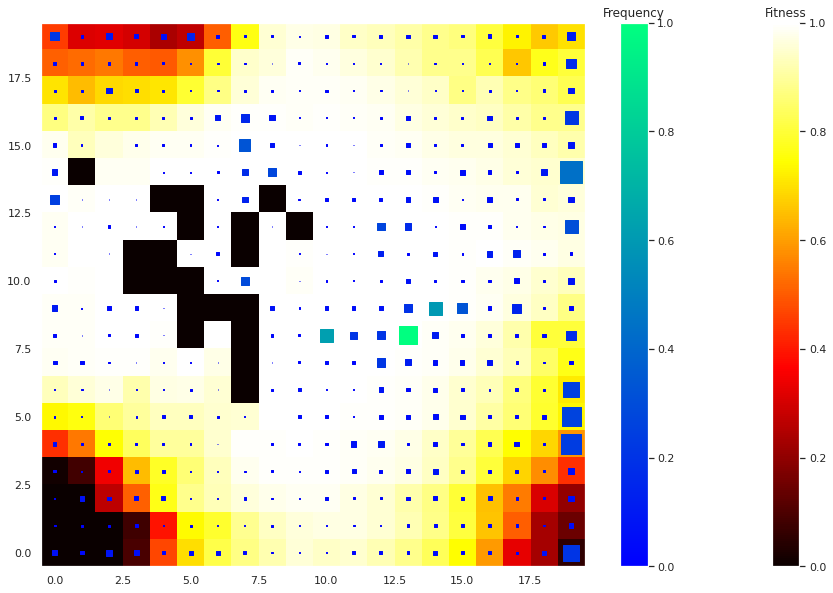

In [27]:
plt.figure(figsize=(16, 10))

fp = (frequencies - np.min(frequencies))/(np.max(frequencies) - np.min(frequencies))
scalefit = (np.max(fits) - fits)/(np.max(fits) - np.min(fits))
scalegen = (gens - np.min(gens))/(np.max(gens) - np.min(gens))

plt.imshow(scalefit.T, cmap='hot', origin='lower')
# plt.pcolormesh(scalefit.T, cmap='hot') 
plt.grid(False)
clb = plt.colorbar()
clb.ax.set_title('Fitness')

xs = []
ys = []
vals = []
for i in range(som_size):
  for j in range(som_size):
    xs.append(i)
    ys.append(j)
    vals.append(500*fp[i][j])
plt.scatter(xs, ys, s=vals, c=scalegen, marker="s", cmap="winter")
clb = plt.colorbar()
clb.ax.set_title('Frequency')
# plt.text(6, 19, progstr[(6,19)])

Text(0.5, 1.0, 'Recency')

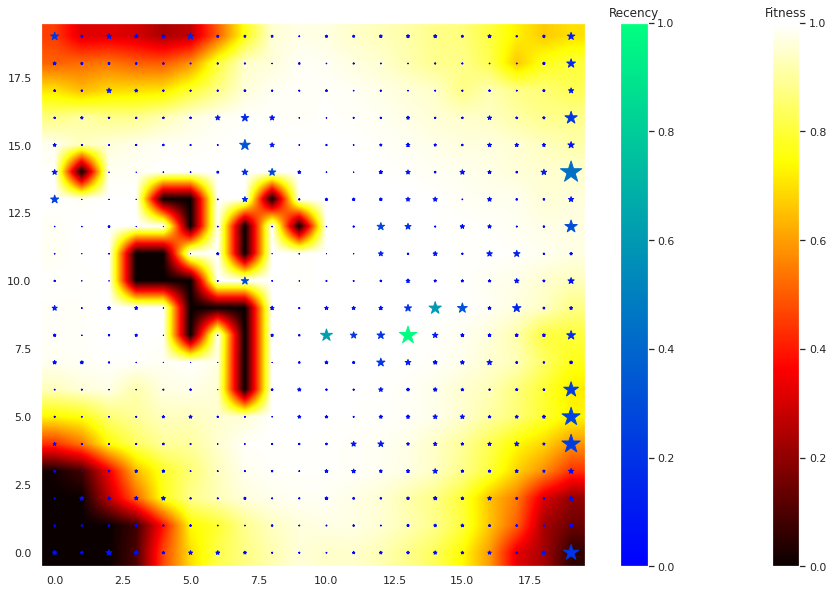

In [28]:
plt.figure(figsize=(16, 10))

fp = (frequencies - np.min(frequencies))/(np.max(frequencies) - np.min(frequencies))
scalefit = (np.max(fits) - fits)/(np.max(fits) - np.min(fits))
scalegen = (gens - np.min(gens))/(np.max(gens) - np.min(gens))

plt.imshow(scalefit.T, cmap='hot', origin='lower', interpolation="bilinear") 
# plt.pcolormesh(scalefit.T, cmap='hot') 
plt.grid(False)
clb = plt.colorbar()
clb.ax.set_title('Fitness')

xs = []
ys = []
vals = []
for i in range(som_size):
  for j in range(som_size):
    xs.append(i)
    ys.append(j)
    vals.append(500*fp[i][j])
plt.scatter(xs, ys, s=vals, c=scalegen, marker="*", cmap="winter")
clb = plt.colorbar()
clb.ax.set_title('Recency')

In [29]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_evolved_program(somidx1=(0, som_size-1, 1), somidy1=(0, som_size-1, 1), 
                         somidx2=(0, som_size-1, 1), somidy2=(0, som_size-1, 1)):
  plt.figure(figsize=(8, 8))
  ix = somidx1
  iy = somidy1
  erx = somidx2
  ery = somidy2
  def probfunction(x):
    return (x**4 + 2*x + 3*x**3)*(np.cos(x*5))
  plt.plot(pheno_sample, probfunction(pheno_sample), color="red", label="true", lw=7, alpha=0.5)
  if (ix, iy) in progstr:
    plt.plot(pheno_sample, toolbox.compile(expr=progstr[(ix, iy)])(pheno_sample), label="som_loc_1", ls="--")
    print("Prog={}".format(progstr[(ix, iy)]))
  if (erx, ery) in progstr:
    plt.plot(pheno_sample, toolbox.compile(expr=progstr[(erx, ery)])(pheno_sample), color="green", ls="-.", label="som_loc_2")

  plt.legend()
# plt.title("Prog={}".format(progstr[(ix, iy)]))

interactive(children=(IntSlider(value=9, description='somidx1', max=19), IntSlider(value=9, description='somid…

In [ ]:
np.min(fp), np.max(fp)

(0.0, 0.1933)